Name: Lim Yu Yang Ian
Class: DAAA/FT/2A/02
Admin No: 2201874

# Importing modules

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import seaborn as sns
import warnings
from itertools import product
from pathlib import Path

# Metrics
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

# Models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from pmdarima.arima import auto_arima

# EDA + Model Selection
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests, pacf, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from statsmodels.tsa.statespace.tools import diff

# Pickle Library = Saving Models 
import pickle

c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set Up

In [2]:
default = (10, 5)
sns.set_style("darkgrid")

In [3]:
df = pd.read_csv("../ST1511-CA2-dataset/Energy Consumption Dataset.csv")
df.head()

,DATE,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
0,1/1/1990,18.0,725.1,548.8
1,1/2/1990,15.8,706.7,640.7
2,1/3/1990,17.3,624.5,511.1
3,1/4/1990,18.9,574.7,515.3
4,1/5/1990,22.0,553.2,488.4


# EDA

Setting up a copy to use for eda purposes

In [4]:
df_eda = df.copy()

In [5]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DATE                           397 non-null    object 
 1   Gas Consumption (tons)         397 non-null    float64
 2   Electricity Consumption (MWh)  397 non-null    float64
 3   Water Consumption (tons)       397 non-null    float64
dtypes: float64(3), object(1)
memory usage: 12.5+ KB


Date is an object type, thus we will need to turn it into a date dtype later. The other values that we will be predicting are all continuos float values. Thus we will not need to alter their values.

In [6]:
df_eda.shape

(397, 4)

In [7]:
df_eda.describe()

,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
count,397.000000,397.000000,397.000000
mean,23.785139,888.472544,484.953652
std,4.903452,153.877594,133.908863
min,11.600000,553.200000,44.400000
25%,20.200000,771.100000,384.400000
50%,23.500000,897.800000,487.400000
75%,27.900000,1005.200000,580.200000
max,46.000000,1294.000000,811.000000


In [8]:
df_eda.isna().sum()

DATE                             0
Gas Consumption (tons)           0
Electricity Consumption (MWh)    0
Water Consumption (tons)         0
dtype: int64

There are no na values, thus we will not need to do handling for it

As said on top, the date column is an object dtype. Thus we will create a new "Date" column below of the correct dtype and drop the original "DATE" column

In [9]:
df['Date'] = pd.to_datetime(df['DATE'], format="%d/%m/%Y")
df = df.drop(["DATE"], axis=1)
df.set_index('Date', inplace=True)
display(df)

,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
Date,,,
1990-01-01,18.0,725.1,548.8
1990-02-01,15.8,706.7,640.7
1990-03-01,17.3,624.5,511.1
1990-04-01,18.9,574.7,515.3
1990-05-01,22.0,553.2,488.4
...,...,...,...
2022-09-01,27.7,986.2,513.3
2022-10-01,31.8,936.1,373.1
2022-11-01,31.0,973.4,343.9


In [10]:
prof = ProfileReport(df_eda, explorative=True)

### Using a heatmap to compare correlation of each value

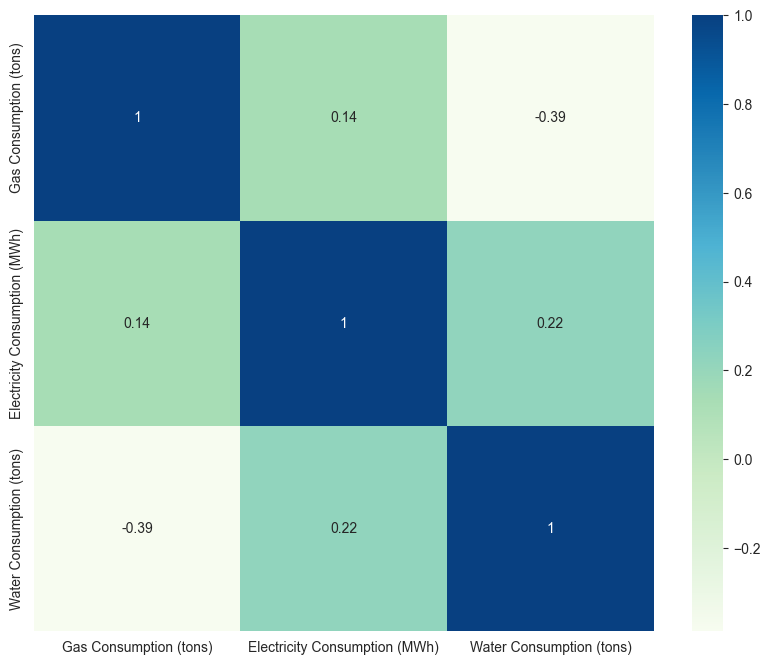

In [11]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap="GnBu")
plt.show()

In [12]:
monthly_gas = df[['Gas Consumption (tons)']]#.mean()
monthly_gas.head()

,Gas Consumption (tons)
Date,
1990-01-01,18.0
1990-02-01,15.8
1990-03-01,17.3
1990-04-01,18.9
1990-05-01,22.0


In [13]:
monthly_electricity = df[['Electricity Consumption (MWh)']]#.mean()
monthly_electricity.head()

,Electricity Consumption (MWh)
Date,
1990-01-01,725.1
1990-02-01,706.7
1990-03-01,624.5
1990-04-01,574.7
1990-05-01,553.2


In [14]:
monthly_water = df[['Water Consumption (tons)']]#.mean()
monthly_water.head()

,Water Consumption (tons)
Date,
1990-01-01,548.8
1990-02-01,640.7
1990-03-01,511.1
1990-04-01,515.3
1990-05-01,488.4


# Time Series Visualisation

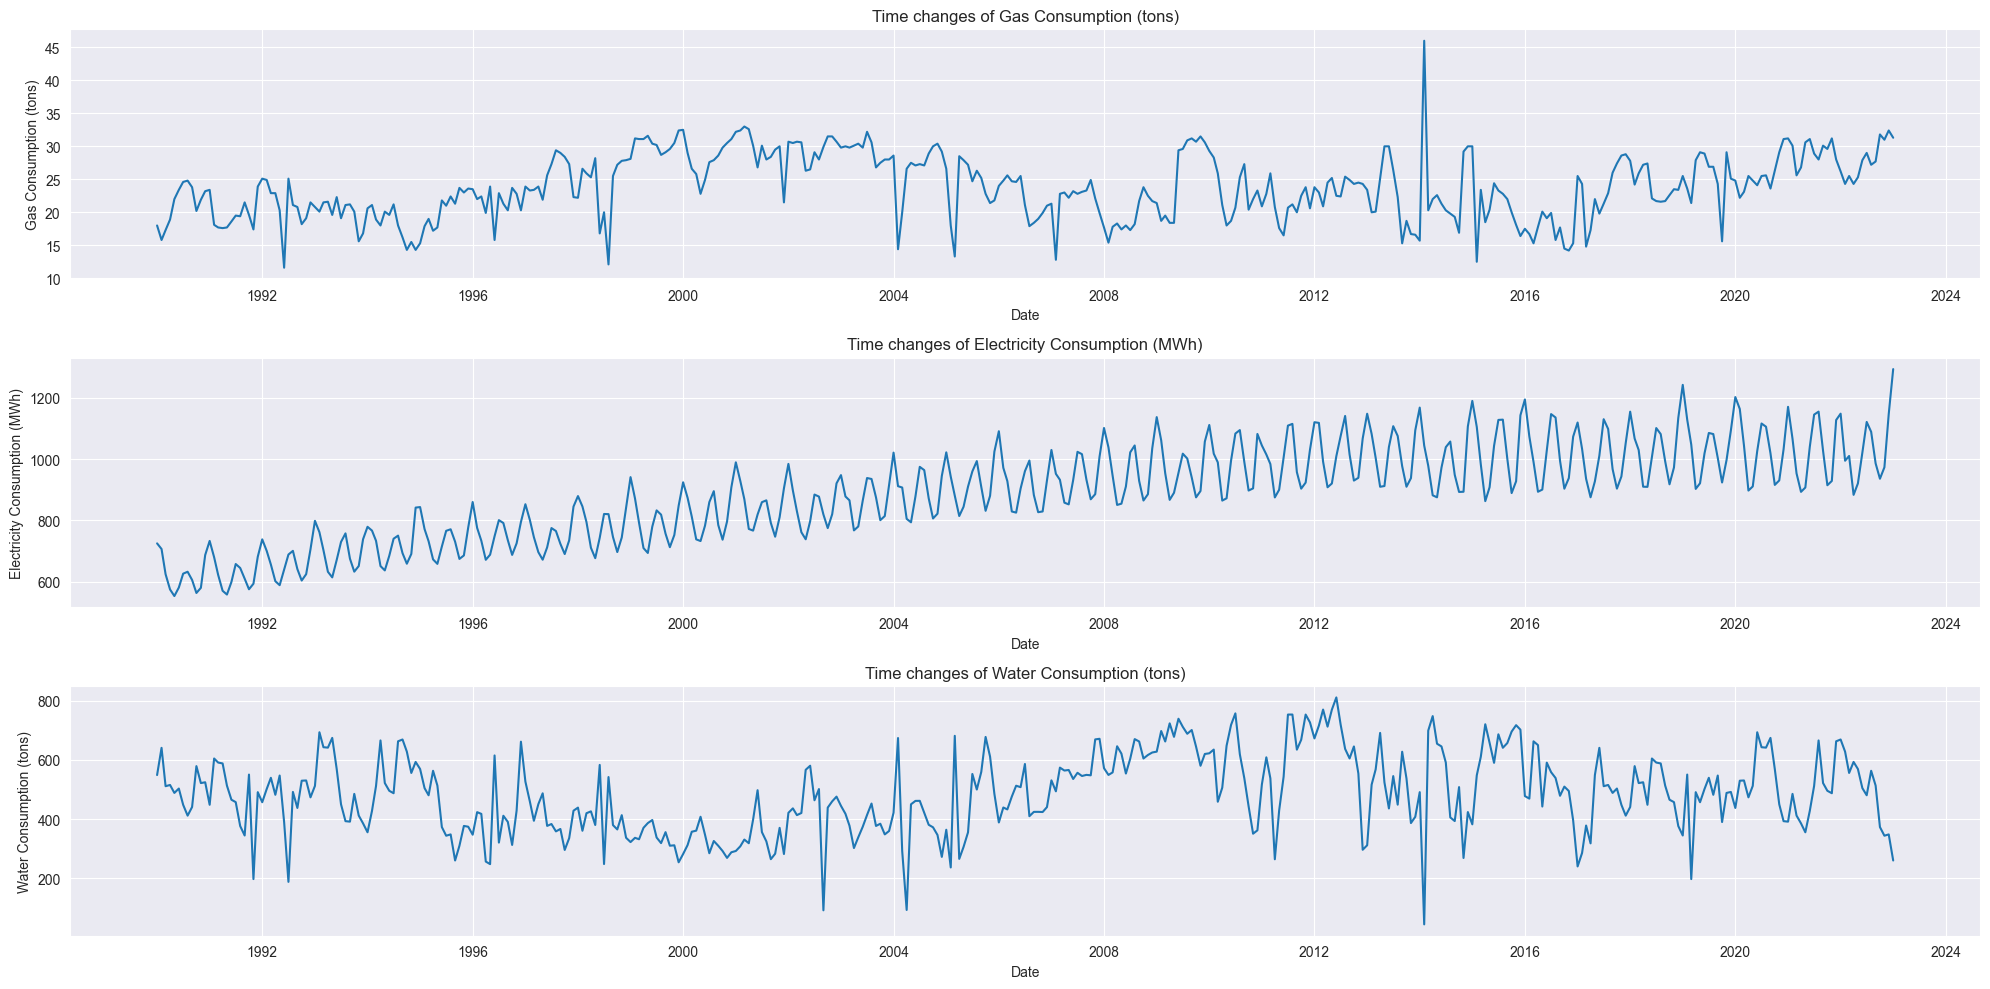

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10), tight_layout=True)
for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    sns.lineplot(df[y_temp], ax=ax[i])
    ax[i].set_title("Time changes of " + y_temp)
    
plt.show()

### Gas Consumption:

There are a lot of spikes which means that there is a very high variance in quantity of Gas Consumption. There is not much of a trend.

### Electicity Comsumption

There is a pattern of a positive upward trend

### Water Consumption

There are a lot of spikes which means that there is a very high variance in quantity of Water Consumption. There is not much of a trend.

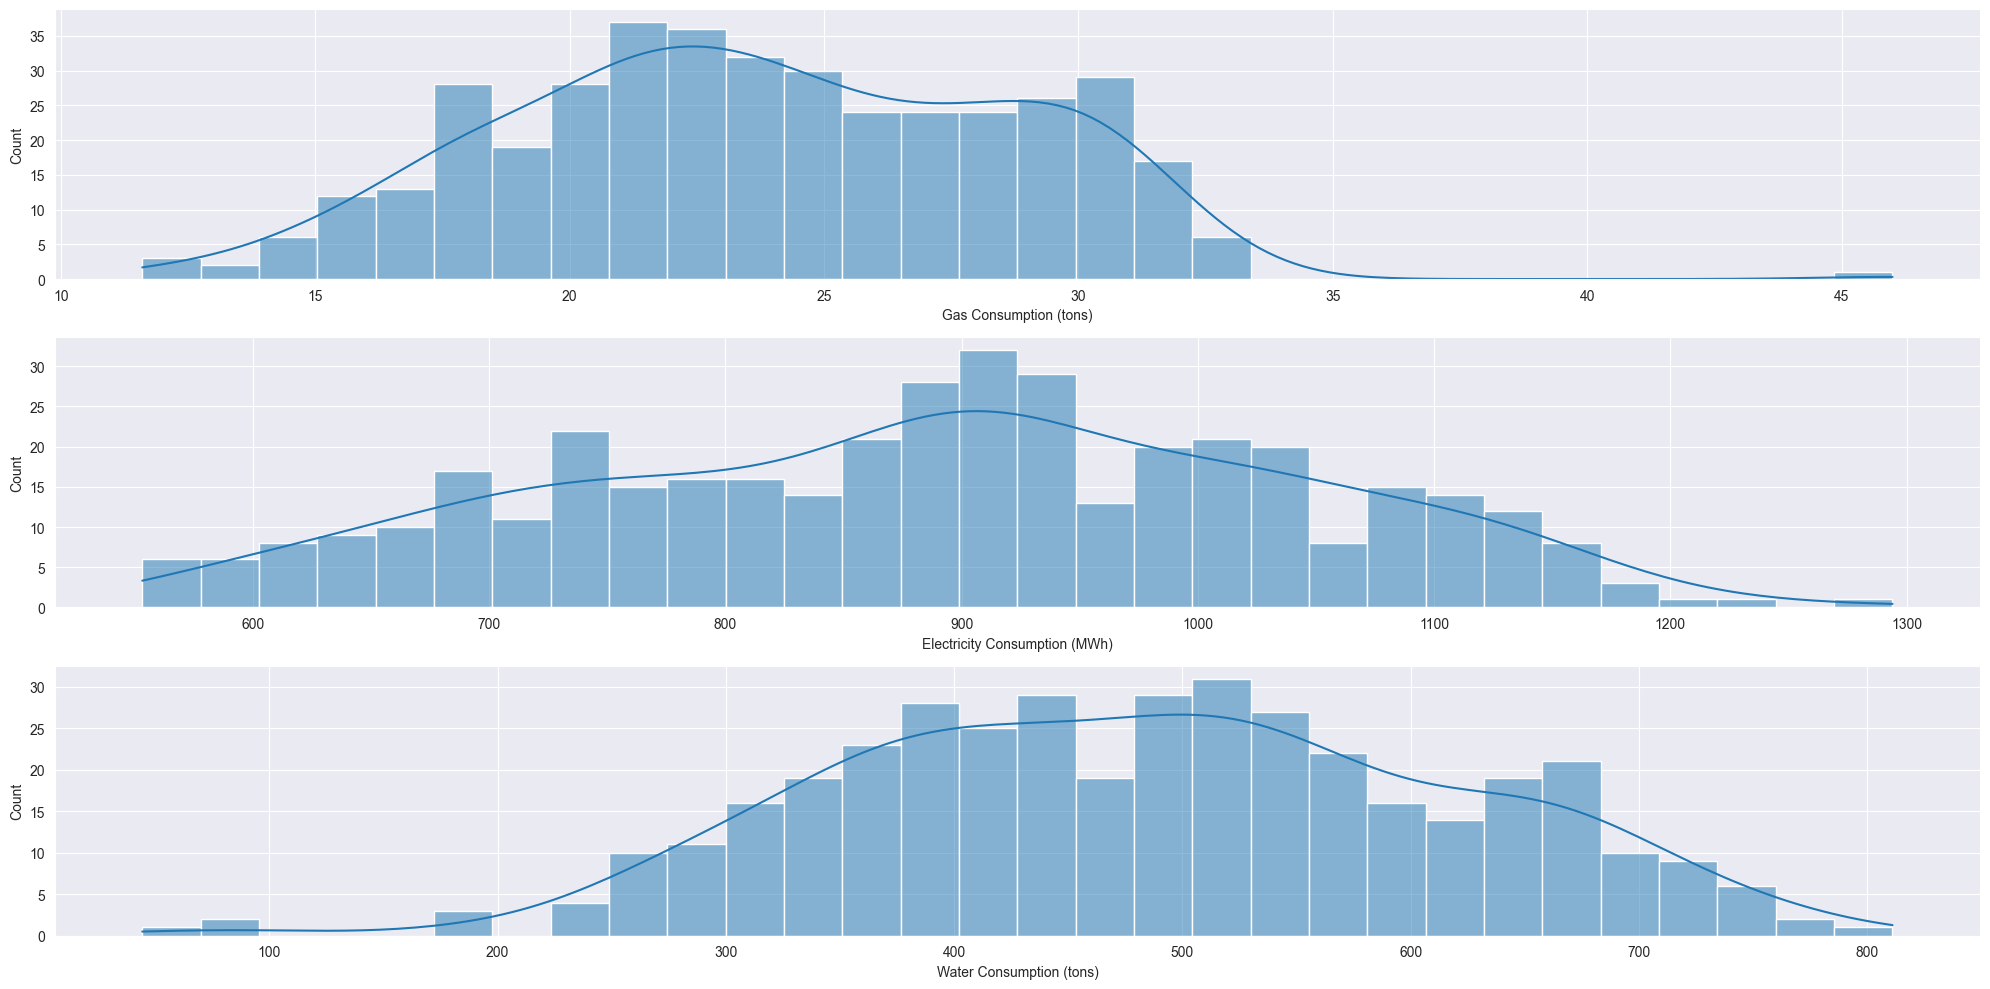

In [16]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10), tight_layout=True)

for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    sns.histplot(data=df, x=y_temp, bins=30, ax=ax[i], kde=True)

# Seasonal Decomposition

Column: Gas Consumption (tons)
Seasonal Decomposition: 12


<Figure size 2000x1000 with 0 Axes>

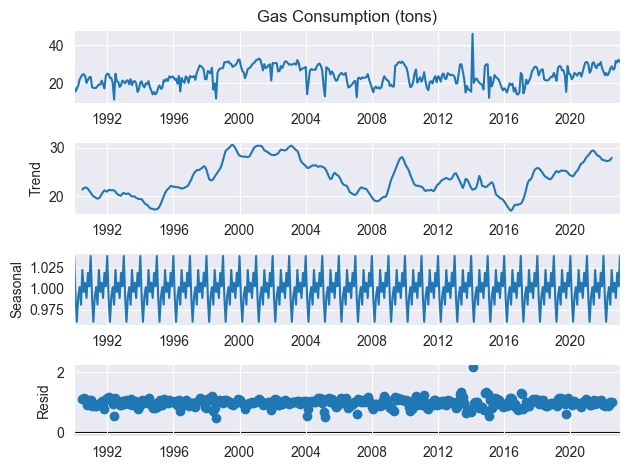

Column: Electricity Consumption (MWh)
Seasonal Decomposition: 12


<Figure size 2000x1000 with 0 Axes>

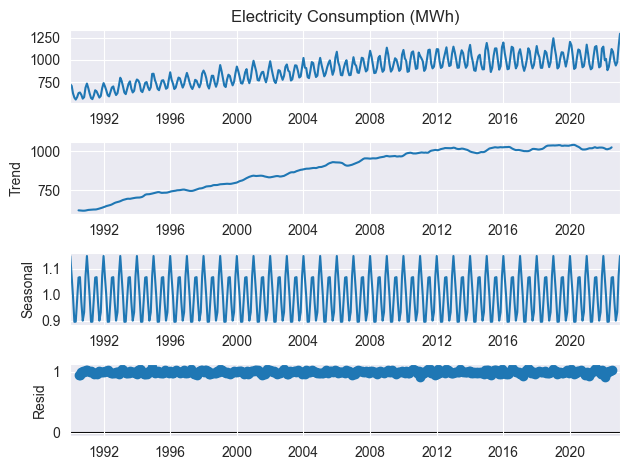

Column: Water Consumption (tons)
Seasonal Decomposition: 12


<Figure size 2000x1000 with 0 Axes>

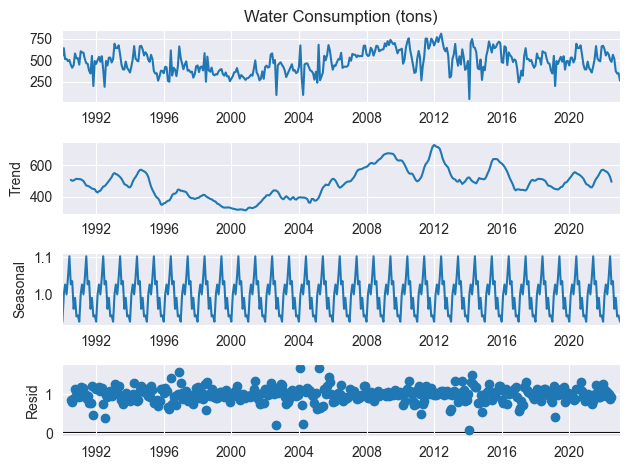

In [17]:
for i in df.columns:
    decomp = seasonal_decompose(df[i], model="multiplicative")

    fig = plt.figure(figsize=(20, 10), tight_layout=True)

    print(f"Column: {i}")
    print(f"Seasonal Decomposition: {len(decomp.seasonal.drop_duplicates())}")

    decomp.plot()
    plt.show()

# Causation

In [18]:
maxlag = 12
test = "ssr_chi2test"

g_matrix = pd.DataFrame(
    np.zeros((len(df.columns), len(df.columns))),
    columns=df.columns,
    index=df.columns,
)
for c in g_matrix.columns:
    for r in g_matrix.index:
        test_result = grangercausalitytests(
            df[[r, c]], maxlag=maxlag, verbose=False
        )
        p_values = [round(test_result[i + 1][0][test][1], 4) for i in range(maxlag)]
        min_p_value = np.min(p_values)
        g_matrix.loc[r, c] = min_p_value
g_matrix.columns = [var + "_x" for var in df.columns]
g_matrix.index = [var + "_y" for var in df.columns]

g_matrix

,Gas Consumption (tons)_x,Electricity Consumption (MWh)_x,Water Consumption (tons)_x
Gas Consumption (tons)_y,1.0000,0.3018,0.2368
Electricity Consumption (MWh)_y,0.1018,1.0000,0.1045
Water Consumption (tons)_y,0.0335,0.0131,1.0000


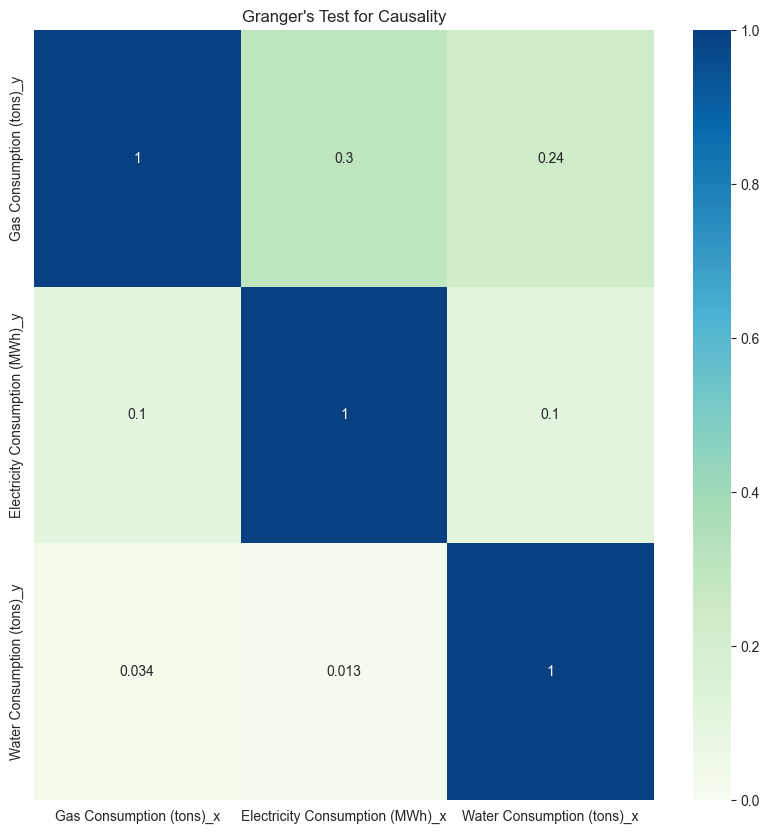

In [19]:
plt.figure(figsize=(10, 10))
sns.heatmap(g_matrix, annot=True, cmap="GnBu", vmin=0, vmax=1)
plt.title("Granger's Test for Causality")
plt.show()

# Cointegration

In [20]:
out = coint_johansen(df, -1, 5)
d = {"0.90": 0, "0.95": 1, "0.99": 2}
traces = out.lr1
cvts = out.cvt[:, d[str(1 - 0.05)]]


def adjust(val, length=6):
    return str(val).ljust(length)


# Summary
print("Name   ::  Test Stat > C(95%)    =>   Significant  \n", "--" * 20)
for col, trace, cvt in zip(df.columns, traces, cvts):
    print(
        adjust(col),
        ":: ",
        adjust(round(trace, 2), 9),
        ">",
        adjust(cvt, 8),
        " =>  ",
        trace > cvt,
    )

Name   ::  Test Stat > C(95%)    =>   Significant  
 ----------------------------------------
Gas Consumption (tons) ::  35.85     > 24.2761   =>   True
Electricity Consumption (MWh) ::  13.78     > 12.3212   =>   True
Water Consumption (tons) ::  1.65      > 4.1296    =>   False


# Covariance

In [21]:
X1 = df.iloc[:len(df)//2, 0]
X2 = df.iloc[len(df)//2:, 0]
print(f'group 1 mean = {X1.mean():.2f}, group 2 mean = {X1.mean():.2f}, \ngroup 1 variance = {X1.var():.2f}, group 2 variance = {X2.var():.2f}')

group 1 mean = 24.28, group 2 mean = 24.28, 
group 1 variance = 24.48, group 2 variance = 23.23


# P-Value

In [22]:
for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    result = adfuller(df[y_temp])
    print(y_temp, 'p-value: %f' % result[1])

Gas Consumption (tons) p-value: 0.010811
Electricity Consumption (MWh) p-value: 0.186218
Water Consumption (tons) p-value: 0.000090


Let H0 be Data is not stationary

Let H1 be Data is stationary

Since the P-value of Gas Consumption and Water Consumption is less that 0.05, we reject the null hypothesis. Thus the data is stationary

Since the P-value of Electricity is more than 0.05, we accept the null hypothesis. Thus the data is not stationary and action needs to be taken.

D - Value

Gas Consumption (tons) Original p-value: 0.010811



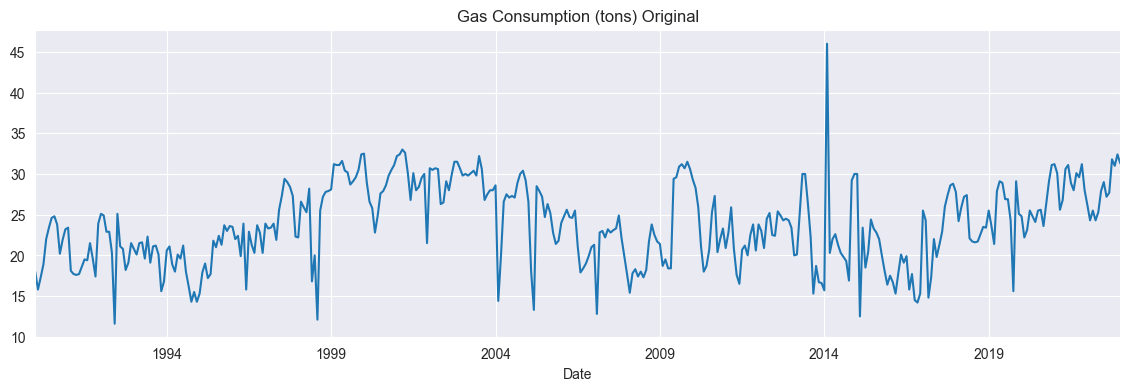

Electricity Consumption (MWh) Original p-value: 0.186218
Electricity Consumption (MWh) After differencing p-value (1 Order): 0.000000



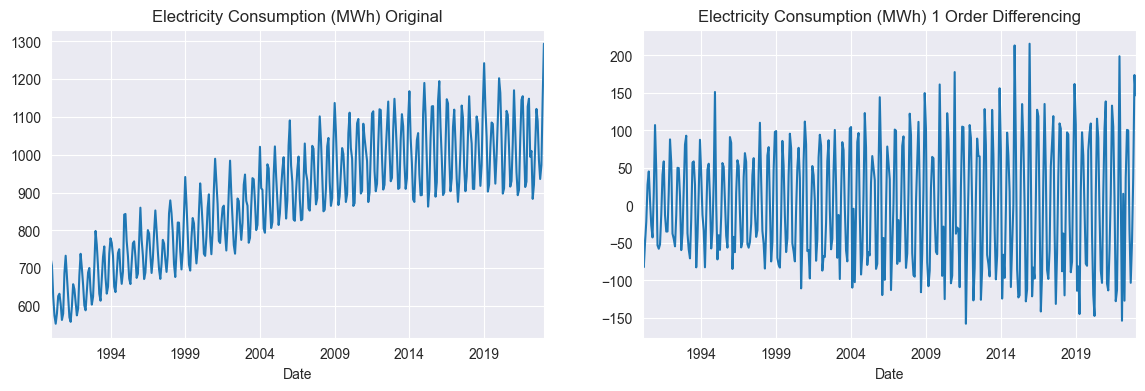

Water Consumption (tons) Original p-value: 0.000090



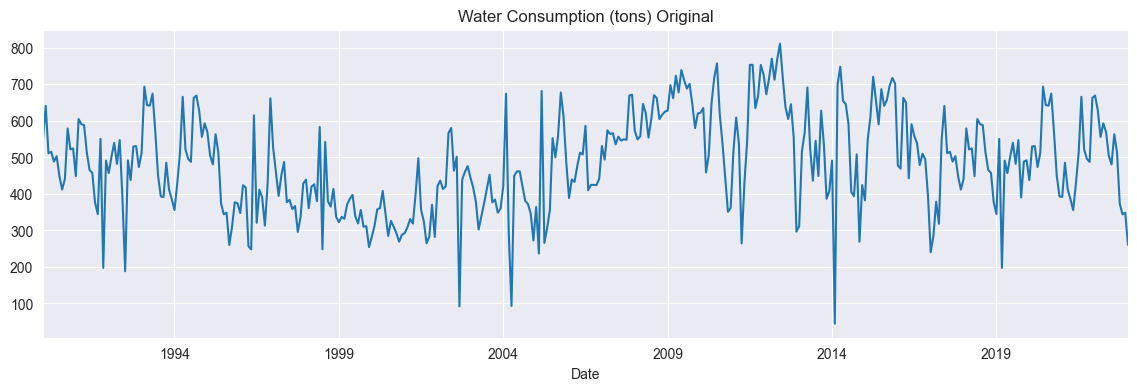

In [23]:
for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    result = adfuller(df[y_temp])
    print(y_temp, 'Original p-value: %f' % result[1])

    count = 0
    while result[1] >= 0.05:
        count += 1
        df_diff = diff(df[y_temp], k_diff=count)

        result = adfuller(df_diff)
        print(y_temp, f'After differencing p-value ({count} Order): %f' % result[1])
    
    print()

    if count >= 1:
        fig, ax = plt.subplots(1, count + 1, figsize=(14, 4))
        df[y_temp].plot(ax=ax[0])
        ax[0].set_title(f'{y_temp} Original')

        for j in range(count):
            df_diff.plot(ax=ax[count])
            ax[count].set_title(f'{y_temp} {count} Order Differencing')
        plt.show()

    else:
        fig = plt.figure(figsize=(14, 4))
        df[y_temp].plot()
        plt.title(f'{y_temp} Original')
        plt.show()

    

### Observations
In a SARIMA model, I need to check if your time series is stationary or not. Using the above, I can identify whether each time series is stationary or not, and how high my k_diff value needs to be for it to be stationary. This will help me identify my differencing order (D) in the SARIMA model below.

Gas Consumption:

The original P-Value is less that 0.05, thus the Value of D would be 0

Electricity Consumption:

The P-Value is more than 0.05 before differencing, and it is below 0.05 after differencing with a k_diff value of 1, thus the Value of D would be 1

Water Consumption:

The original P-Value is less that 0.05, thus the Value of D would be 0

# Partial/ Autocorrelation Function Analysis

Gas:
ACF Shows GD at 0 order. PACF shows significant lags at 1 and 13. 1 is the most significant lag.
d = 0, q = 0, p = 1

Electricity:
ACF Shows GD at 1st order. PACF shows significant lags at 2 and 12. Test both as they are similar.
d = 1, q = 1, p = 2/12

Water:
ACF Shows GD at 0 order. PACF shows significant lag at 1. 
d = 0, q = 0, p = 1

c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


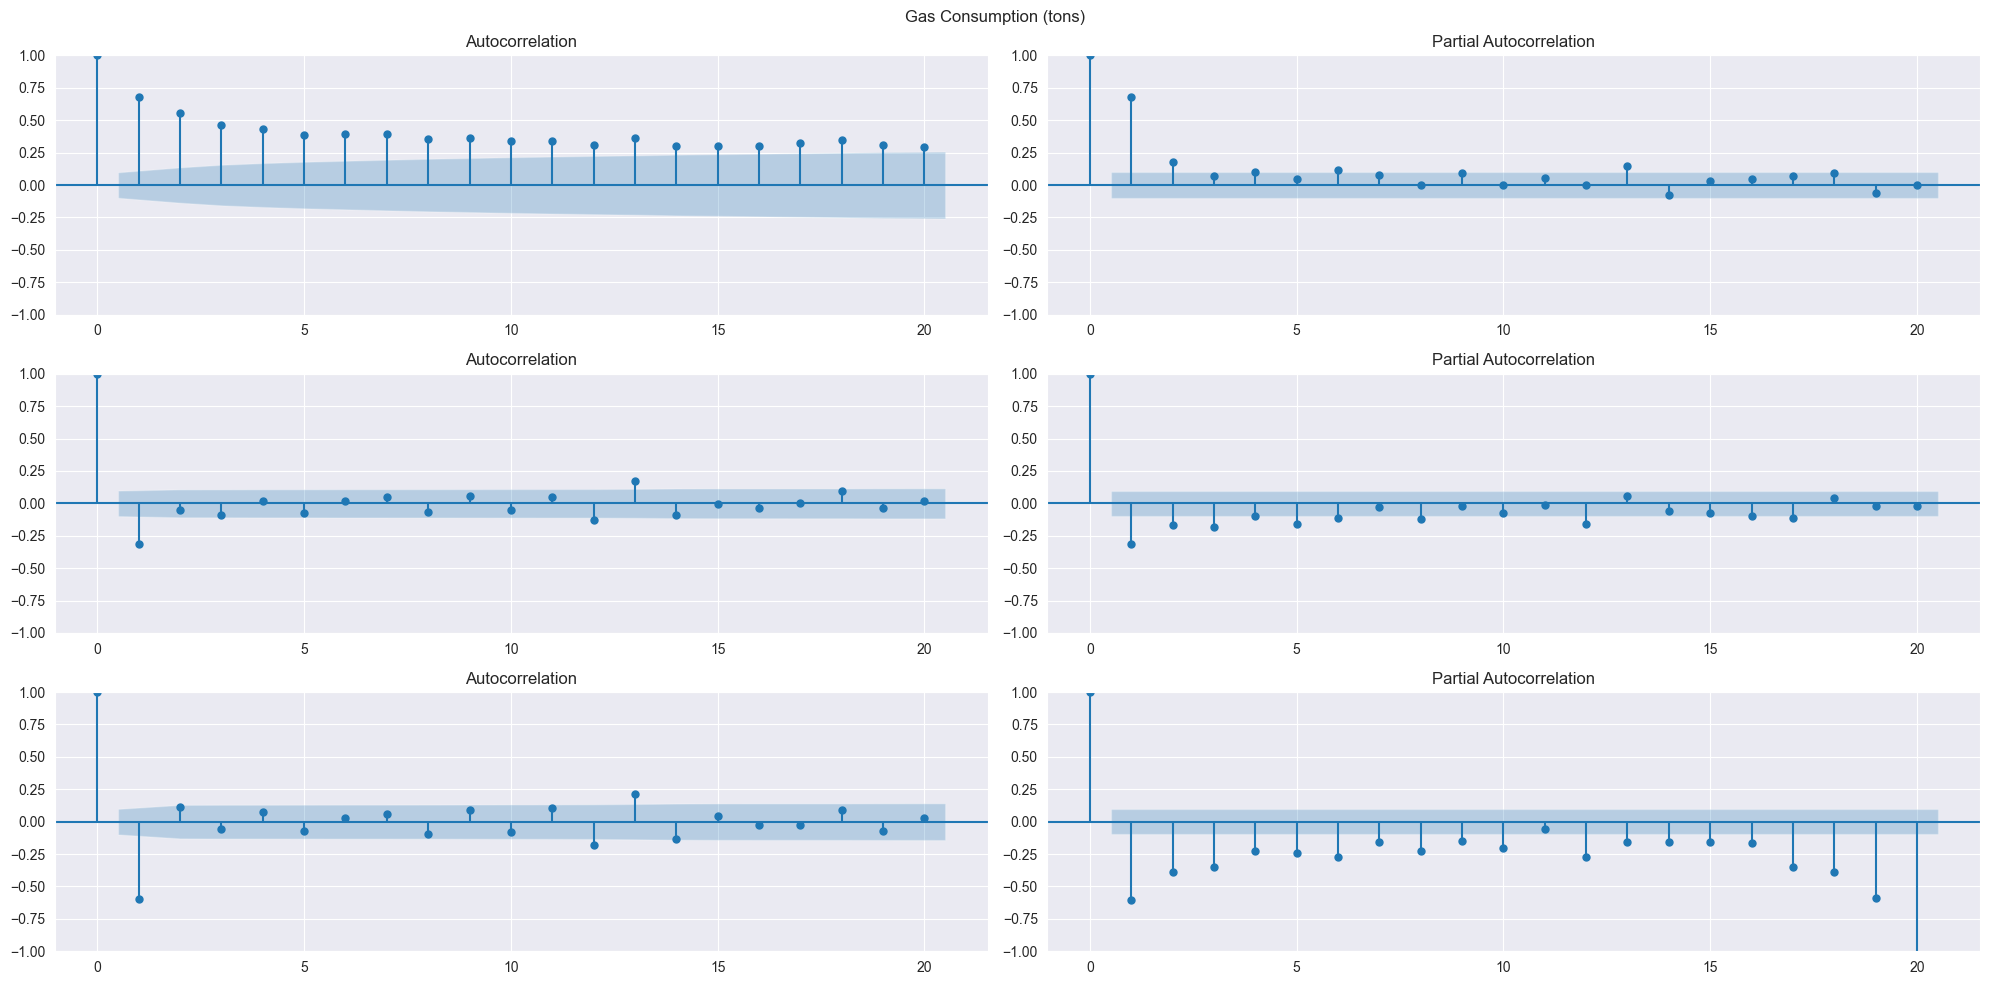

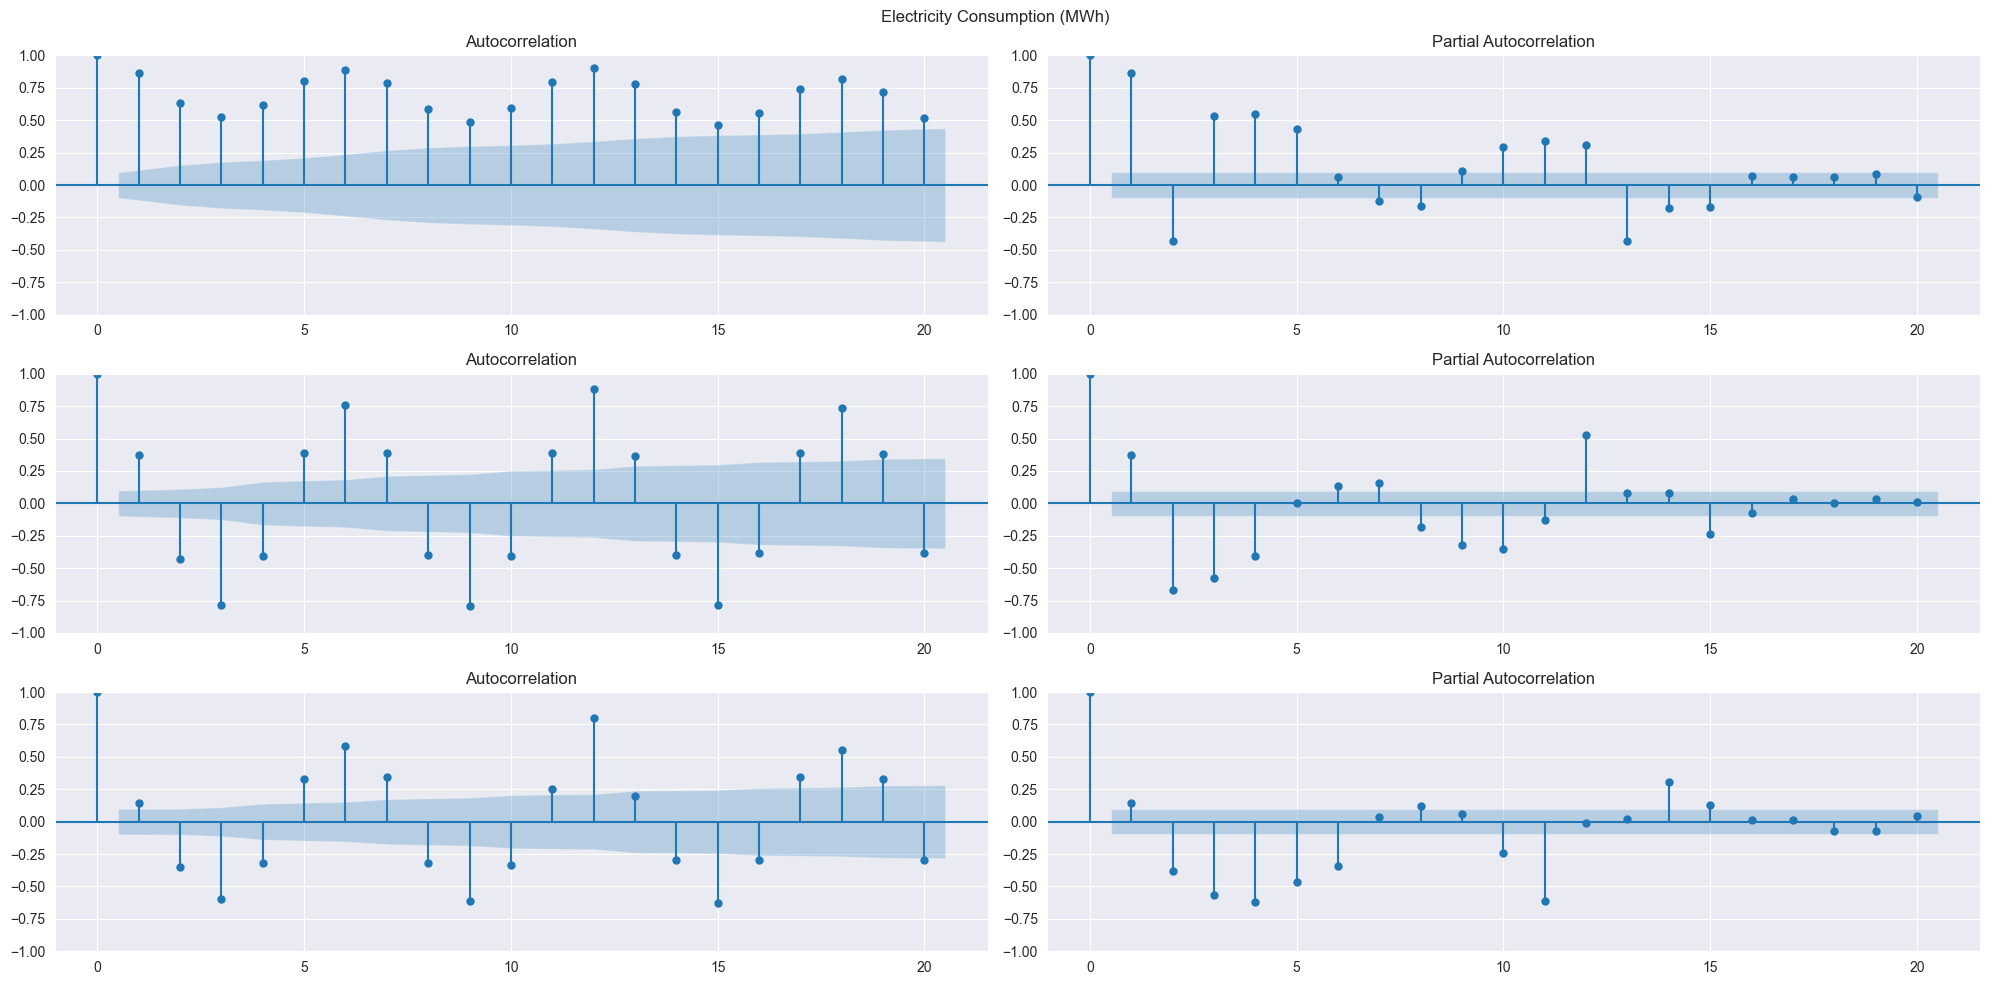

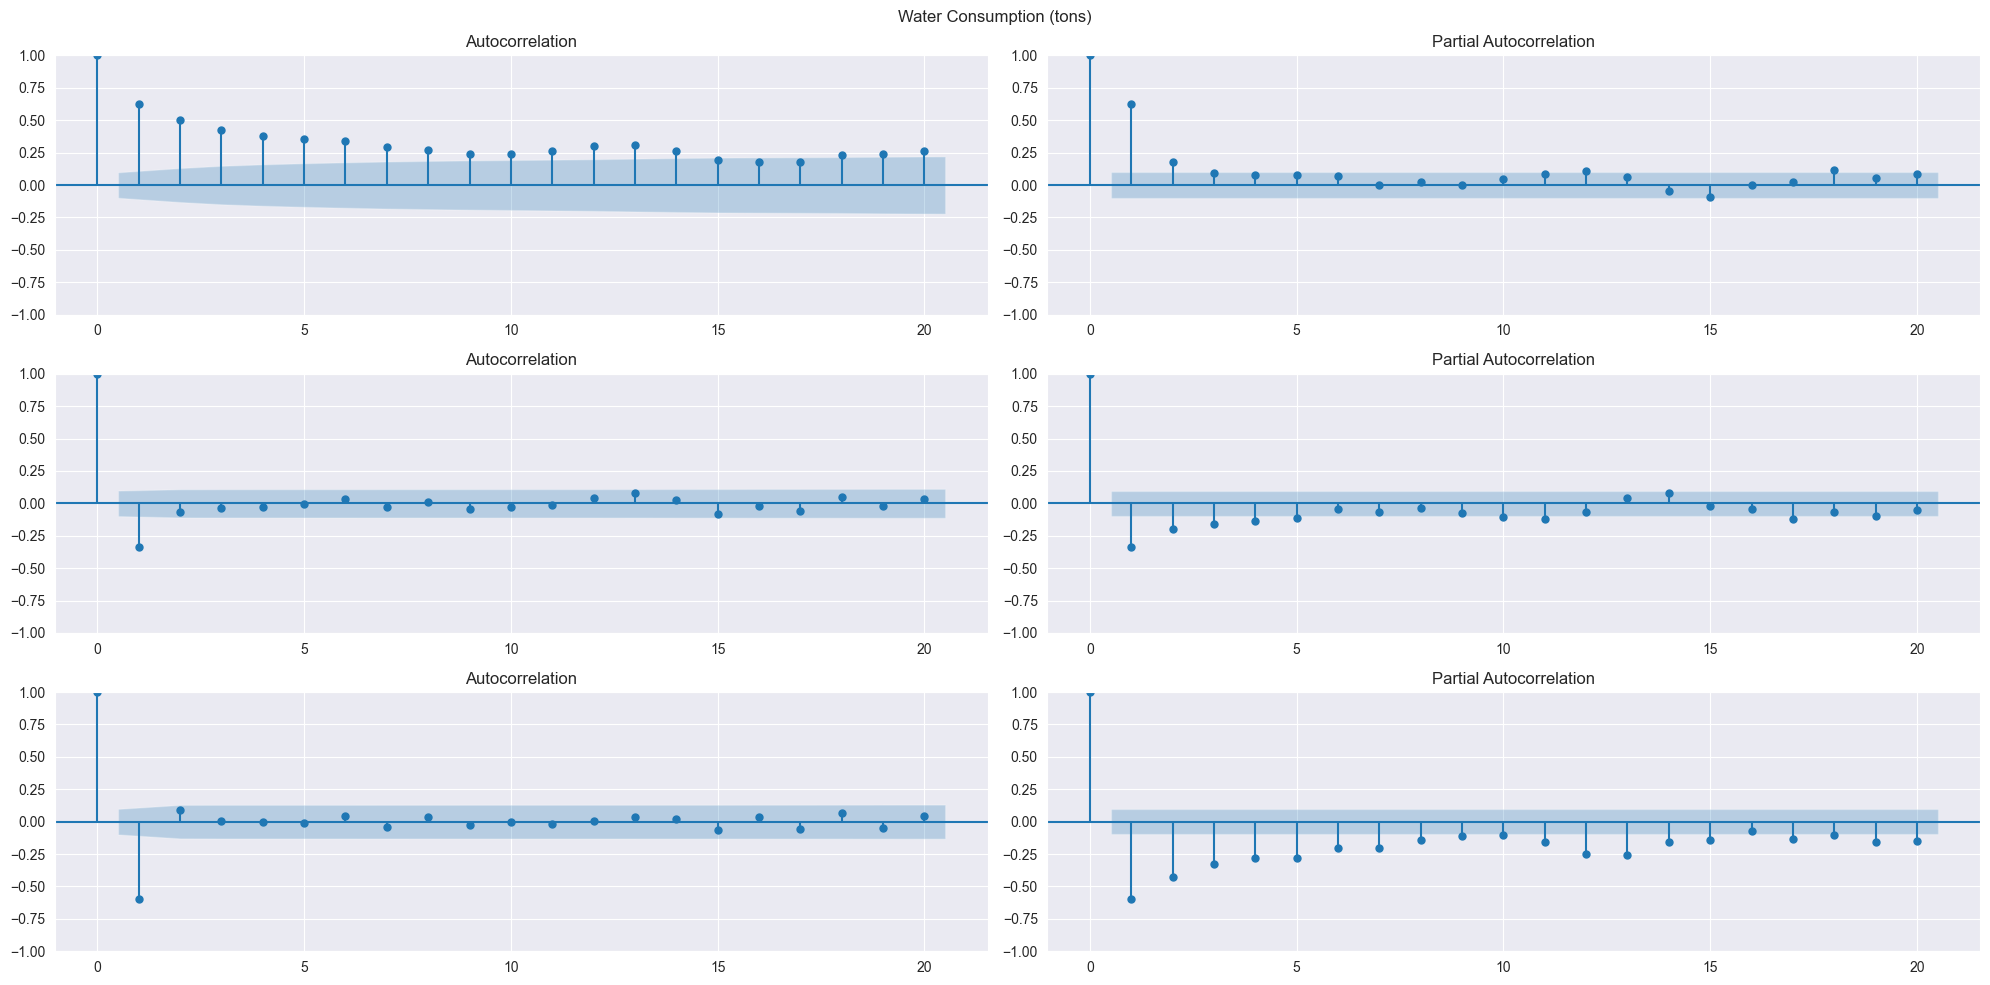

In [24]:
for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    fig, ax = plt.subplots(3, 2, figsize=(20, 10), tight_layout=True)
    plot_acf(df[y_temp], lags=20, ax=ax[0,0])
    plot_pacf(df[y_temp], lags=20, ax=ax[0,1])

    plot_acf(df[y_temp].diff().dropna(), lags=20, ax=ax[1,0])
    plot_pacf(df[y_temp].diff().dropna(), lags=20, ax=ax[1,1])

    plot_acf(df[y_temp].diff().diff().dropna(), lags=20, ax=ax[2,0])
    plot_pacf(df[y_temp].diff().diff().dropna(), lags=20, ax=ax[2,1])

    fig.suptitle(y_temp)
    plt.show()

## ACF:

To find the value of q, we need to use the ACF plot. Which will tell me the moving average, and how much is required to remove the autocorrelation from the stationary time series.

# Splitting Data

In [25]:
trainSize = int(len(df) * 0.8)
y_train, y_test = df[:trainSize], df[trainSize:]
print(f"y train: {y_train.shape}")
print(f"y test: {y_test.shape}")

y train: (317, 3)
y test: (80, 3)


In [26]:
y_train_dic = {}
y_test_dic = {}
for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    y_train_dic[y_temp], y_test_dic[y_temp] = y_train[y_temp], y_test[y_temp]

# ARIMA Baseline

                                 SARIMAX Results                                  
Dep. Variable:     Gas Consumption (tons)   No. Observations:                  317
Model:                     ARIMA(1, 1, 1)   Log Likelihood                -851.861
Date:                    Mon, 07 Aug 2023   AIC                           1709.721
Time:                            23:14:17   BIC                           1720.989
Sample:                        01-01-1990   HQIC                          1714.223
                             - 05-01-2016                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4200      0.043      9.873      0.000       0.337       0.503
ma.L1         -0.9052      0.036    -24.899      0.000      -0.976      -0.834
sigma2        12.815

c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


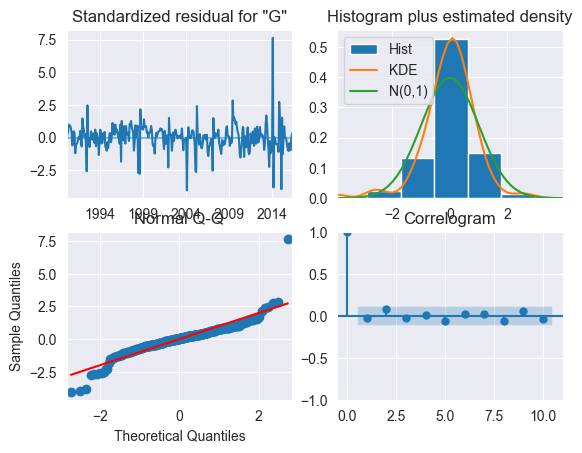

c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:     Electricity Consumption (MWh)   No. Observations:                  317
Model:                            ARIMA(1, 1, 1)   Log Likelihood               -1750.289
Date:                           Mon, 07 Aug 2023   AIC                           3506.578
Time:                                   23:14:18   BIC                           3517.845
Sample:                               01-01-1990   HQIC                          3511.079
                                    - 05-01-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0470      0.101      0.466      0.641      -0.151       0.245
ma.L1          0.5738      0.075      7.696

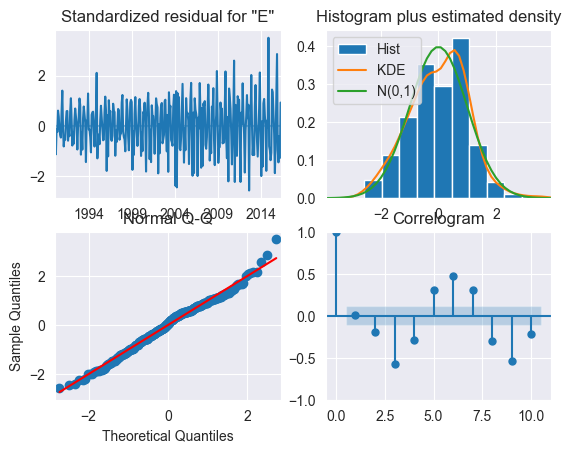

c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                  SARIMAX Results                                   
Dep. Variable:     Water Consumption (tons)   No. Observations:                  317
Model:                       ARIMA(1, 1, 1)   Log Likelihood               -1915.981
Date:                      Mon, 07 Aug 2023   AIC                           3837.961
Time:                              23:14:19   BIC                           3849.228
Sample:                          01-01-1990   HQIC                          3842.462
                               - 05-01-2016                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3952      0.050      7.891      0.000       0.297       0.493
ma.L1         -0.9167      0.026    -34.879      0.000      -0.968      -0.865
sigm

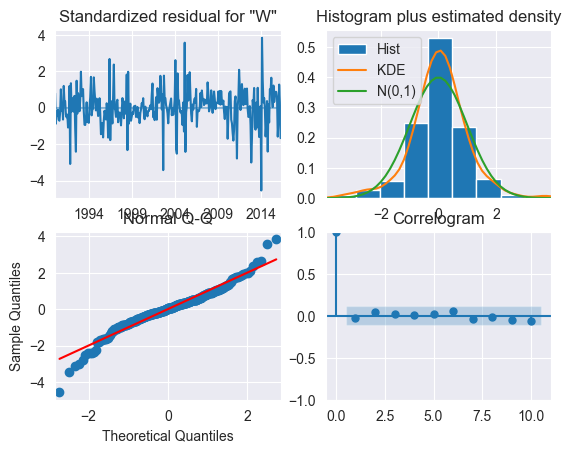

In [27]:
model_list = []
for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    model_list.append(ARIMA(y_train_dic[y_temp], order=(1, 1, 1)).fit())
    print(model_list[i].summary())
    model_list[i].plot_diagnostics()
    plt.show()

# SARIMA

In [28]:
def model_cv(
    model, endog, order=(1, 1, 1), splits=3, seasonal_order=None, max_iter=1000
):
    valid_rmse = []
    valid_mape = []
    train_rmse = []
    train_mape = []
    model_aic = []
    model_bic = []
    time_series = TimeSeriesSplit(n_splits=splits)
    for train_index, test_index in time_series.split(endog):
        y_train, y_test = endog.iloc[train_index], endog.iloc[test_index]
        if seasonal_order is None:
            model_fit = model(endog=y_train, order=order).fit(
                maxiter=max_iter, disp=False
            )
        else:
            model_fit = model(
                endog=y_train, seasonal_order=seasonal_order, order=order
            ).fit(maxiter=max_iter, disp=False)
        y_pred = model_fit.predict(
            start=y_test.index[0], end=y_test.index[-1]
        )
        valid_rmse.append(mean_squared_error(y_test, y_pred, squared=False))
        valid_mape.append(mean_absolute_percentage_error(y_test, y_pred))
        train_pred = model_fit.predict(
            start=y_train.index[0], end=y_train.index[-1]
        )
        train_rmse.append(mean_squared_error(y_train, train_pred, squared=False))
        train_mape.append(mean_absolute_percentage_error(y_train, train_pred))
        model_aic.append(model_fit.aic)
        model_bic.append(model_fit.bic)
    return (
        pd.Series(
            {
                "train_rmse": np.mean(train_rmse),
                "train_rmse_std": np.std(train_rmse),
                "valid_rmse": np.mean(valid_rmse),
                "valid_rmse_std": np.std(valid_rmse),
                "train_mape": np.mean(train_mape),
                "valid_mape": np.mean(valid_mape),
                "AIC": np.mean(model_aic),
                "BIC": np.mean(model_bic),
            },
            name=order,
        ),
        pd.DataFrame(
            {
                "train_rmse": train_rmse,
                "train_rmse_std": train_rmse,
                "valid_rmse": valid_rmse,
                "valid_rmse_std": valid_rmse,
                "train_mape": train_mape,
                "valid_mape": valid_mape,
                "AIC": model_aic,
                "BIC": model_bic,
            }
        ),
    )

In [29]:
model_list = []
resource_pred = []
resource_test = []

# Seasonal Order (P, D, Q, S)
gas_sorder = (0, 0, 1, 12)
electricity_sorder = (0, 1, 1, 12)
water_sorder = (0, 0, 1, 12)
seasonal_list = [gas_sorder, electricity_sorder, water_sorder]

# Order (p, d, q)
gas_order = (1, 0, 1)
electricity_order = (1, 1, 5)
water_order = (1, 0, 1)
order_list = [gas_order, electricity_order, water_order]

In [30]:
avg_scores = []
cv_table = []
for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    score, cv = model_cv(
        SARIMAX, endog=df[y_temp], splits=5, seasonal_order=seasonal_list[i], order=order_list[i]
    )
    avg_scores.append(score)
    cv_table.append(cv)

c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(da

In [31]:
for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    print(y_temp)
    display(cv_table[i])

Gas Consumption (tons)


,train_rmse,train_rmse_std,valid_rmse,valid_rmse_std,train_mape,valid_mape,AIC,BIC
0,3.462503,3.462503,8.631356,8.631356,0.117803,0.274582,334.924106,343.742876
1,3.266560,3.266560,4.098332,4.098332,0.106400,0.122627,670.818875,682.380272
2,3.360824,3.360824,4.954720,4.954720,0.104952,0.165498,1028.967220,1042.140439
3,3.290504,3.290504,5.035074,5.035074,0.103939,0.149598,1364.267353,1378.586272
4,3.843317,3.843317,8.620539,8.620539,0.119083,0.287096,1820.463347,1835.671821


Electricity Consumption (MWh)


,train_rmse,train_rmse_std,valid_rmse,valid_rmse_std,train_mape,valid_mape,AIC,BIC
0,100.035733,100.035733,42.333357,42.333357,0.047007,0.048359,481.229714,497.141586
1,72.046547,72.046547,33.964584,33.964584,0.032399,0.032932,1047.028005,1069.327939
2,59.987931,59.987931,35.537106,35.537106,0.027902,0.030043,1630.303364,1656.109338
3,53.570894,53.570894,66.655673,66.655673,0.026075,0.055595,2262.201275,2290.436708
4,49.410631,49.410631,35.986625,35.986625,0.025037,0.025739,2891.751605,2921.848016


Water Consumption (tons)


,train_rmse,train_rmse_std,valid_rmse,valid_rmse_std,train_mape,valid_mape,AIC,BIC
0,116.670599,116.670599,109.733895,109.733895,0.188258,0.226887,813.668473,822.487243
1,102.513182,102.513182,196.815470,196.815470,0.176900,0.397096,1589.430466,1600.991863
2,108.181850,108.181850,150.709683,150.709683,0.216842,0.215375,2413.941810,2427.115030
3,104.020555,104.020555,182.012492,182.012492,0.193579,0.521426,3196.832901,3211.151821
4,111.206310,111.206310,117.061918,117.061918,0.222272,0.184531,4045.388759,4060.597232


                                 SARIMAX Results                                  
Dep. Variable:     Gas Consumption (tons)   No. Observations:                  317
Model:                     ARIMA(1, 0, 0)   Log Likelihood                -865.233
Date:                    Mon, 07 Aug 2023   AIC                           1736.466
Time:                            23:14:30   BIC                           1747.743
Sample:                        01-01-1990   HQIC                          1740.970
                             - 05-01-2016                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.3947      0.630     37.113      0.000      22.159      24.630
ar.L1          0.6641      0.034     19.270      0.000       0.597       0.732
sigma2        13.724

c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


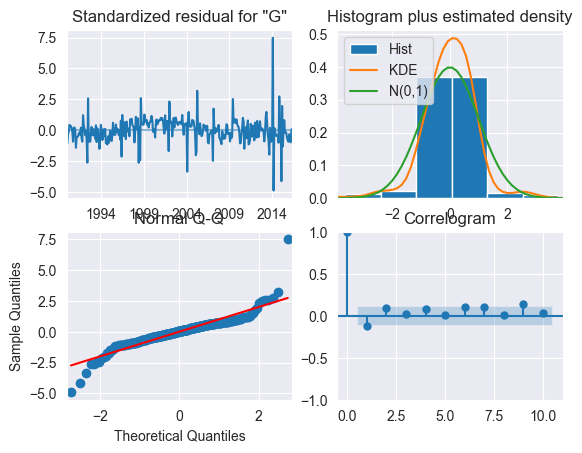

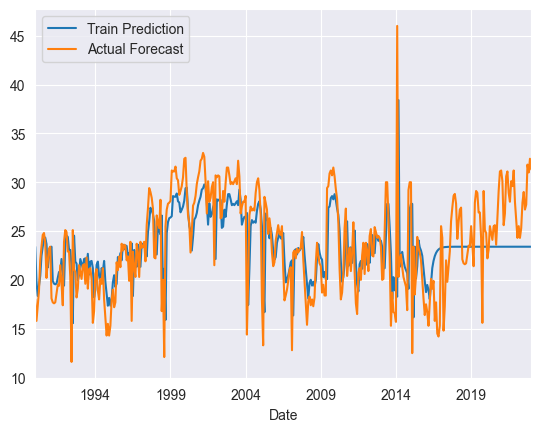

c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:     Electricity Consumption (MWh)   No. Observations:                  317
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 6)   Log Likelihood               -1463.017
Date:                           Mon, 07 Aug 2023   AIC                           2936.034
Time:                                   23:14:31   BIC                           2954.716
Sample:                               01-01-1990   HQIC                          2943.502
                                    - 05-01-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2604      0.054     -4.806      0.000      -0.367      -0.154
ar.L2         -0.3129      0.055     -5.728

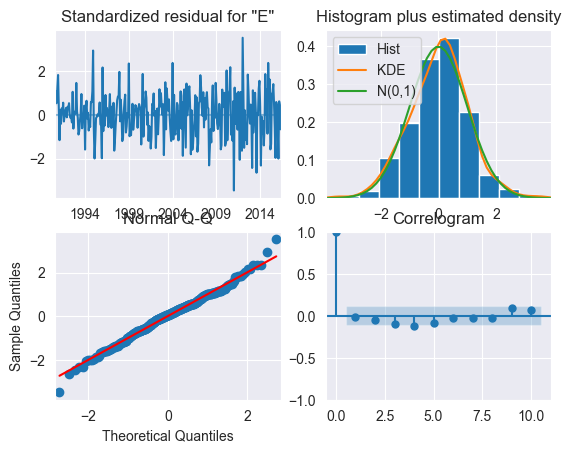

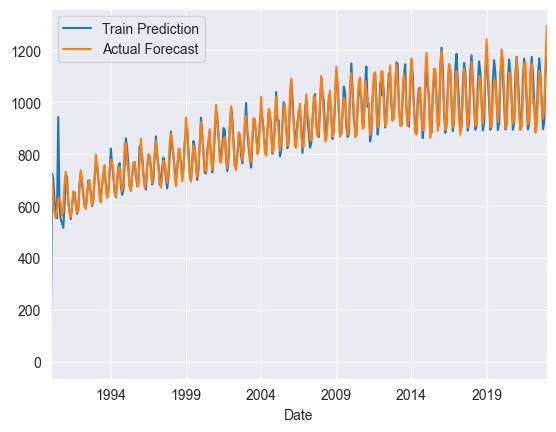

c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                  SARIMAX Results                                   
Dep. Variable:     Water Consumption (tons)   No. Observations:                  317
Model:                       ARIMA(1, 0, 0)   Log Likelihood               -1934.183
Date:                      Mon, 07 Aug 2023   AIC                           3874.367
Time:                              23:14:32   BIC                           3885.644
Sample:                          01-01-1990   HQIC                          3878.871
                               - 05-01-2016                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        483.6795     17.623     27.446      0.000     449.139     518.221
ar.L1          0.6383      0.042     15.042      0.000       0.555       0.721
sigm

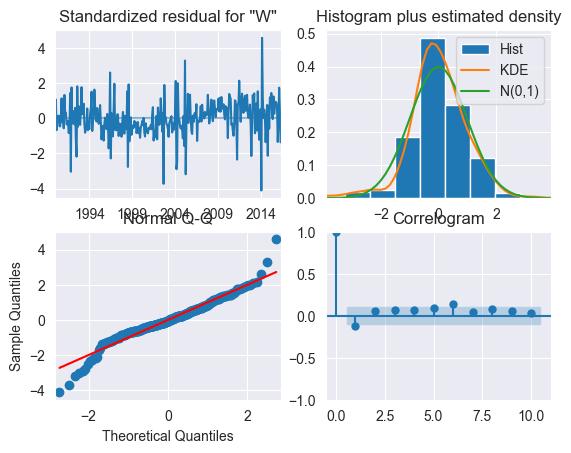

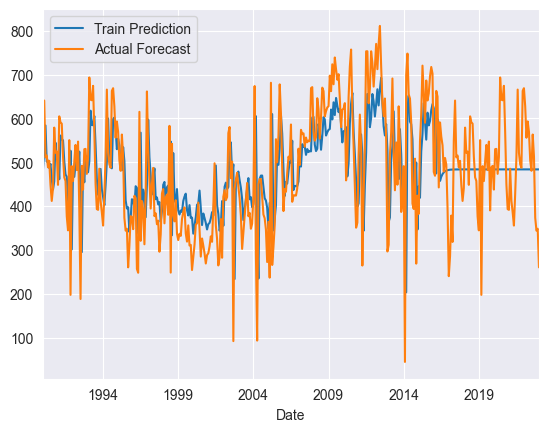

In [32]:
# Seasonal Order (P, D, Q, S)
gas_sorder = (1, 0, 0, 12)
electricity_sorder = (2, 1, 0, 6)
water_sorder = (1, 0, 0, 12)
seasonal_list = [gas_sorder, electricity_sorder, water_sorder]

# Order (p, d, q)
gas_order = (1, 0, 0)
electricity_order = (2, 1, 0)
water_order = (1, 0, 0)
order_list = [gas_order, electricity_order, water_order]

model_list = []

for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    if y_temp in ["Gas Consumption (tons)", "Water Consumption (tons)"]:
        model_list.append(ARIMA(y_train_dic[y_temp], order=order_list[i]).fit())
    else:
        model_list.append(
            SARIMAX(
                y_train_dic[y_temp],
                order=order_list[i],
                seasonal_order=seasonal_list[i],
            ).fit()
        )

    print(model_list[i].summary())
    model_list[i].plot_diagnostics()
    plt.show()

    resource_pred.append(model_list[i].predict(
        start=y_train_dic[y_temp].index[0], end=y_test_dic[y_temp].index[-1]))
    #resource_test.append(model_list[i].predict(start=y_test_dic[y_temp].index[0], end=y_test_dic[y_temp].index[-1]))

    fig = plt.figure()
    resource_pred[i].plot(label="Train Prediction")
    #resource_test[i].plot(label="SARIMAX Test Prediction")
    df[y_temp].plot(label="Actual Forecast")
    plt.legend()
    plt.show()
